In [ ]:
### Encoding model for iEEG
# Pedro Pinheiro-Chagas
# Adapted from Christopher Holdgraf's git repo: 
#(https://github.com/choldgraf/paper-encoding_decoding_electrophysiology)

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from modelingtools import delay_time_series, plot_activity_on_brain
from modelingtools import (plot_cv_indices, cross_validate_alpha)

from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
#from sklearn.learning_curve import learning_curve
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, r2_score

import os
import seaborn as sns
import matplotlib.collections as clt
import ptitprince as pt

import sys
np.set_printoptions(threshold=sys.maxsize)

from sklearn import cross_validation as cv



/Users/pinheirochagas/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Users/pinheirochagas/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 1. The data
Task: MMR - calculation, memory verification and "rest" ('17+5=23', 'I ate fruit today'). <br/>
Type of data: epoched and baseline corrected, all concatenated. <br />
Brain feature: Normalized HFB power.  <br />

Stimuli features:
0. Task, trial, time, block
1. Task
    - condition(calculation, memory, rest) 
    - type (active, passive)
2. Calculation specs
    - number_format (digit, word, dot)
    - operand_1
    - operand_2
    - operand_min
    - operand_max
    - operation (addition, subtraction, multiplication)
    - ls_sl
    - result 
    - cross_decade
    - presented_result
    - abs_deviant
    - number of digits
3. Memory specs
    - memory type (autobio, self-external, self-internal, fact)
4. Behavior
    - RT
    - Accuracy
    - RT_lock
    
The features were already selected and the encoding matrix was consctructed in Matlab and saved as csv.

### Load the data

In [2]:
data = pd.read_csv('/Users/pinheirochagas/Pedro/Stanford/code/lbcn_encoding_decoding/data/data_61.csv') 
data.head()
# Set extreme values to zero (double check spike exclusion)
data.loc[data.loc[:,'HFB']>30, 'HFB'] = 0
# Recode task name
data.loc[data.loc[:,'task_general_cond_name']==4, 'task_general_cond_name'] = 2
data.loc[data.loc[:,'task_general_cond_name']==6, 'task_general_cond_name'] = 1

In [3]:
# Select math trials 
data = data.loc[data.loc[:,'task_general_cond_name'] == 2,:]
data = data.reset_index()
data.head()



,index,task,trial,time,elect,HFB,block,task_general_cond_name,task_type,number_format,...,cross_decade,presented_result,abs_deviant,number_of_digits,memory_type,RT,accuracy,StimulusOnsetTime,allonsets,RT_lock
0,1001,7,2,0.000,61,-0.138345,1,2,1,1,...,1,38,101,5,0,3.931649,1,93433.878793,24.384229,28.315878
1,1002,7,2,0.002,61,-0.250269,1,2,1,1,...,1,38,101,5,0,3.931649,1,93433.878793,24.384229,28.315878
2,1003,7,2,0.004,61,-0.358473,1,2,1,1,...,1,38,101,5,0,3.931649,1,93433.878793,24.384229,28.315878
3,1004,7,2,0.006,61,-0.449242,1,2,1,1,...,1,38,101,5,0,3.931649,1,93433.878793,24.384229,28.315878
4,1005,7,2,0.008,61,-0.509151,1,2,1,1,...,1,38,101,5,0,3.931649,1,93433.878793,24.384229,28.315878


In [4]:
times = np.shape(np.unique(data.loc[:,'time']))
times = int(times[0])
r,c = np.shape(data)
trials = int(r/times)

In [5]:
data.head()

,index,task,trial,time,elect,HFB,block,task_general_cond_name,task_type,number_format,...,cross_decade,presented_result,abs_deviant,number_of_digits,memory_type,RT,accuracy,StimulusOnsetTime,allonsets,RT_lock
0,1001,7,2,0.000,61,-0.138345,1,2,1,1,...,1,38,101,5,0,3.931649,1,93433.878793,24.384229,28.315878
1,1002,7,2,0.002,61,-0.250269,1,2,1,1,...,1,38,101,5,0,3.931649,1,93433.878793,24.384229,28.315878
2,1003,7,2,0.004,61,-0.358473,1,2,1,1,...,1,38,101,5,0,3.931649,1,93433.878793,24.384229,28.315878
3,1004,7,2,0.006,61,-0.449242,1,2,1,1,...,1,38,101,5,0,3.931649,1,93433.878793,24.384229,28.315878
4,1005,7,2,0.008,61,-0.509151,1,2,1,1,...,1,38,101,5,0,3.931649,1,93433.878793,24.384229,28.315878


In [6]:
times = np.shape(np.unique(data.loc[:,'time']))
times = int(times[0])
r,c = np.shape(data)
trials = int(r/times)
trials_rs = np.matlib.repmat(np.arange(1,trials+1),times,1).T
trials_rs = trials_rs.reshape(-1,1)
data['trials'] = trials_rs

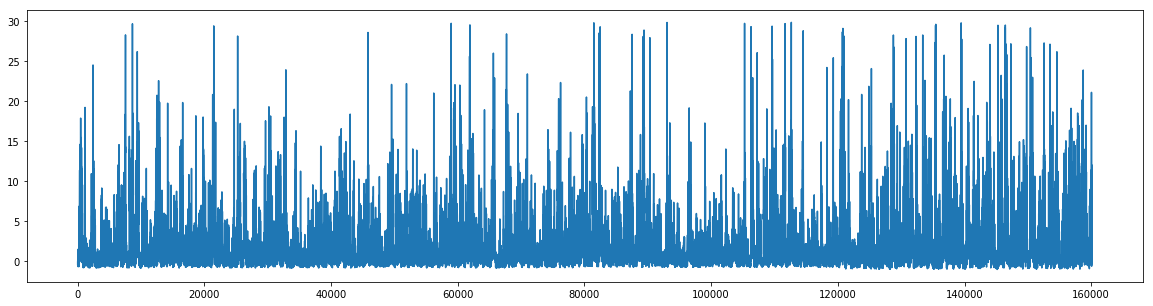

In [7]:
# Vizualize
fig, ax = plt.subplots(1,1,figsize=(20, 5))
ax.plot(data.loc[:,'HFB'])

In [8]:
features = np.array(data.loc[:,'task_general_cond_name']) # result
times = np.shape(np.unique(data.loc[:,'time']))
times = int(times[0])
r,c = np.shape(data)
trials = int(r/times)

# Reshape features
features_reshape = np.reshape(features, (trials, times))
features_reshape = np.expand_dims(features_reshape, axis=1)

# Add delayed features
fs = 500
time_window = 0.02;
#n_delays = 100
#delays = np.linspace(1, 2, 100)

start = 0; stop = 1.5; step = time_window
delays = np.arange(start, stop+step, step)
n_delays = int(len(delays))

X_delayed = np.zeros((trials,1,n_delays,times))
for i in range(trials):
    for ii in range(n_delays):
        window = [int(np.round(delays[ii]*fs)),int(np.round((delays[ii]+time_window)*fs))]
        X_delayed[i,0,ii,window[0]:window[1]] = int(np.unique(features_reshape[i]))
        
# Concatenate back the delayed features
X_env = X_delayed.reshape([X_delayed.shape[0], -1, X_delayed.shape[-1]])
X = np.hstack(X_env).T

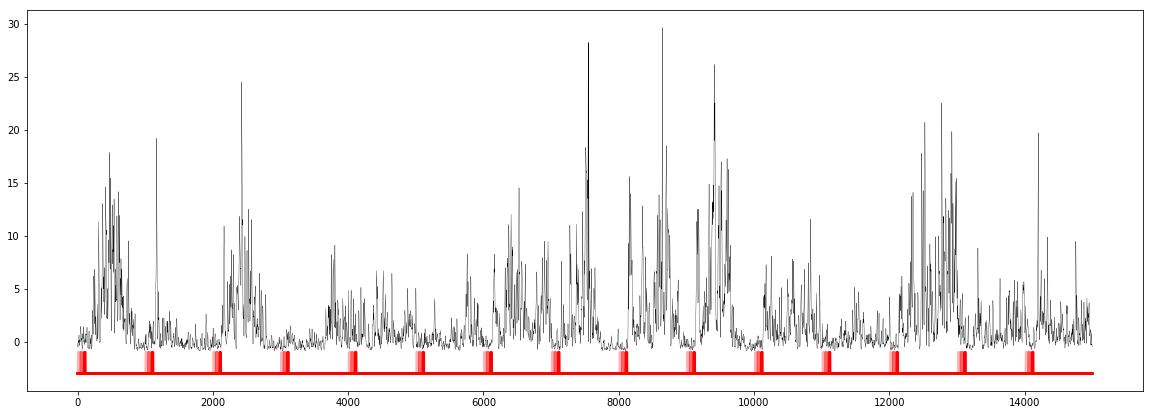

In [9]:
fig, ax = plt.subplots(figsize=(20, 7))
ax = plt.plot(data.loc[0:15000,'HFB'], 'k', linewidth=0.3)
ax = plt.plot(X[0:15000,10]-3, color = [1, 0, 0, 1], linewidth=3)
ax = plt.plot(X[0:15000,5]-3, color = [1, 0, 0, 0.6], linewidth=3)
ax = plt.plot(X[0:15000,1]-3, color = [1, 0, 0, 0.3], linewidth=3)

In [10]:
# Define the dependent variable
y = np.array(data.loc[:,'HFB']) # HFB

# Fit the model
est = make_pipeline(StandardScaler(), LinearRegression())
est.fit(X, y)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

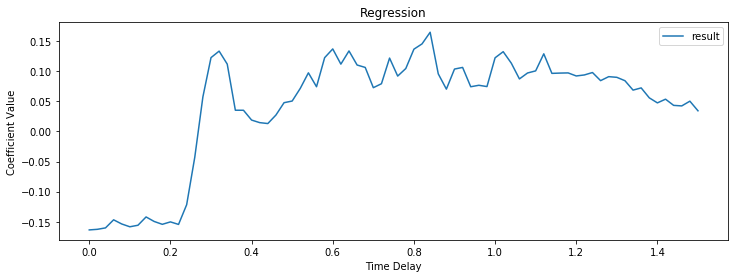

In [11]:
# Plot results
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.abs(delays), est.steps[-1][-1].coef_, label = 'result')

ax.set_xlabel('Time Delay')
ax.set_ylabel('Coefficient Value')
ax.set_title('Regression')
ax.legend()

In [12]:
predictions = est.predict(X_env)

ValueError: Found array with dim 3. StandardScaler expected <= 2.

NameError: name 'predictions' is not defined

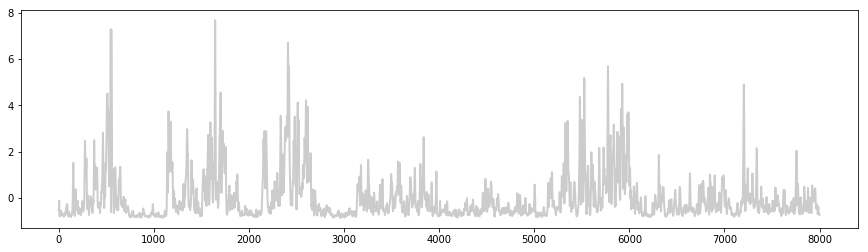

In [13]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(scale(y[7000:15000]), color='k', alpha=.2, lw=2)
ax.plot(scale(predictions[7000:15000]), color='r', lw=2)


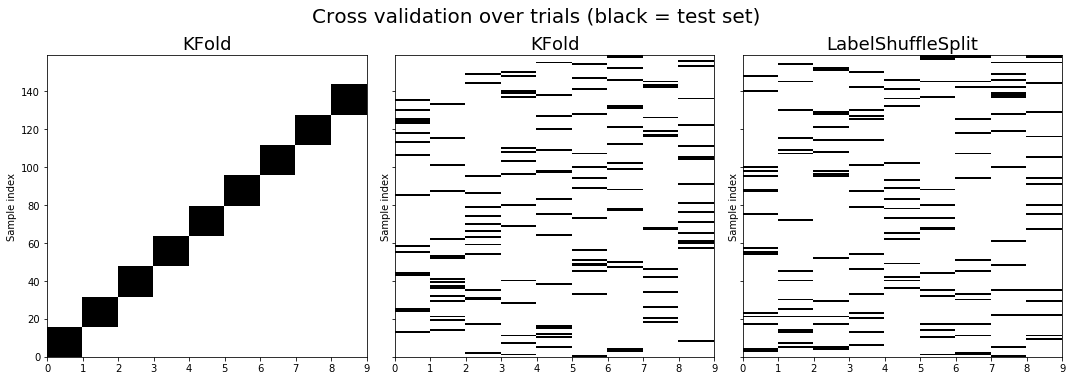

In [14]:
# Iterating across trials (labels)
n_cv_iterations = 10
trials = (np.unique(data.loc[:,'trial']))
cv_iterators = [cv.KFold(len(trials), n_folds=n_cv_iterations),
                cv.KFold(len(trials), n_folds=n_cv_iterations, shuffle=True),
                cv.LabelShuffleSplit(trials, n_iter=n_cv_iterations,
                                     test_size=.1)]

fig, axs = plt.subplots(1, len(cv_iterators), figsize=(15, 5),
                        sharey=True, sharex=True)
for ax, icv in zip(axs, cv_iterators):
    ax = plot_cv_indices(icv, ax)
    ax.set_title(type(icv).__name__, fontsize=18)
fig.suptitle('Cross validation over trials (black = test set)',
             fontsize=20, y=1.05)
plt.tight_layout()

In [15]:
len(np.unique(data.loc[:,'trial']))

160

In [16]:
# We'll use the KFold iterator, shuffling trial numbers first
cross_val_iterator = cv.KFold(len(trials), n_folds=5, shuffle=True)
model = Ridge(alpha=1e5)

In [17]:
dir_data = '/Volumes/LBCN8T_2/Stanford/data/encoding/'

scores_all = []
for i in range(0,128):
    data = pd.read_csv(dir_data + 'data_' + str(i+1) + '.csv') 
    # Set extreme values to zero (double check spike exclusion)
    data.loc[data.loc[:,'HFB']>30, 'HFB'] = 0
    # Recode task name and organize data
    data.loc[data.loc[:,'task_general_cond_name']==4, 'task_general_cond_name'] = 2
    data.loc[data.loc[:,'task_general_cond_name']==6, 'task_general_cond_name'] = 1
    #data = data.loc[data.loc[:,'task_general_cond_name'] == 2,:]
    data = data.reset_index()
    
    # Correct trial count
    times = np.shape(np.unique(data.loc[:,'time']))
    times = int(times[0])
    r,c = np.shape(data)
    trials = int(r/times)
    trials_rs = np.matlib.repmat(np.arange(1,trials+1),times,1).T
    trials_rs = trials_rs.reshape(-1,1)
    data['trials'] = trials_rs

    # Define dependent variable
    y = np.array(data.loc[:,'HFB']) # HFB
    
    scores = []
    # Iterate through cross-validation splits
    for ax, (tr, tt) in zip(axs, cross_val_iterator):
        # Pull the training / testing data for the ecog data
        y_tr = y[data['trials'].isin(tr)]    
        y_tt = y[data['trials'].isin(tt)]

        # Pull the training / testing data for the spectrogram
        X_tr = X[data['trials'].isin(tr)]    
        X_tt = X[data['trials'].isin(tt)]    

        # Scale all the features for simplicity
        X_tr = scale(X_tr)
        X_tt = scale(X_tt)
        y_tr = scale(y_tr)
        y_tt = scale(y_tt)

        # Fit the model, and use it to predict on new data
        model.fit(X_tr, y_tr)
        predictions = model.predict(X_tt)

        # Get the average (R2)
        scores.append(r2_score(y_tt, predictions))

    scores_all.append(np.mean(scores))

FileNotFoundError: [Errno 2] File /Volumes/LBCN8T_2/Stanford/data/encoding/data_1.csv does not exist: '/Volumes/LBCN8T_2/Stanford/data/encoding/data_1.csv'

In [37]:
for (tr,tt) in zip(cross_val_iterator):


SyntaxError: unexpected EOF while parsing (<ipython-input-37-1cd1a1c21eb7>, line 1)

In [36]:
tr

((array([  0,   1,   2,   3,   5,   6,   7,   8,  11,  12,  13,  15,  16,
          17,  18,  19,  20,  21,  22,  23,  25,  27,  28,  29,  30,  32,
          34,  35,  36,  38,  39,  40,  43,  44,  45,  46,  47,  48,  49,
          51,  52,  53,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
          65,  66,  67,  69,  70,  71,  72,  73,  74,  75,  76,  77,  80,
          81,  82,  83,  85,  86,  87,  88,  89,  90,  91,  93,  94,  95,
          96,  97,  98,  99, 100, 101, 102, 103, 104, 106, 107, 108, 110,
         112, 113, 114, 115, 116, 117, 118, 120, 122, 124, 126, 127, 128,
         130, 131, 132, 133, 134, 136, 137, 138, 139, 141, 142, 143, 144,
         145, 146, 148, 149, 151, 152, 153, 155, 156, 158, 159]),
  array([  4,   9,  10,  14,  24,  26,  31,  33,  37,  41,  42,  50,  54,
          68,  78,  79,  84,  92, 105, 109, 111, 119, 121, 123, 125, 129,
         135, 140, 147, 150, 154, 157])),)

In [393]:
scores_all = np.array(scores_all)

In [458]:
yy_tr = np.stack((y_tr, y_tr), axis=-1)
yy_tt = np.stack((y_tt, y_tt), axis=-1)

In [454]:
print(y_tr.shape)
print(X_tr.shape)
print(yy_tr.shape)


(127127,)
(127127, 76)
(127127, 2)


In [455]:
model.fit(X_tr, yy_tr)
predictions = model.predict(X_tt)

In [464]:
predictions.shape

(32032, 2)

0.06642070694709434
0.0395503607316936
0.06565326478525269
0.01887283154425179
0.047199975426733265


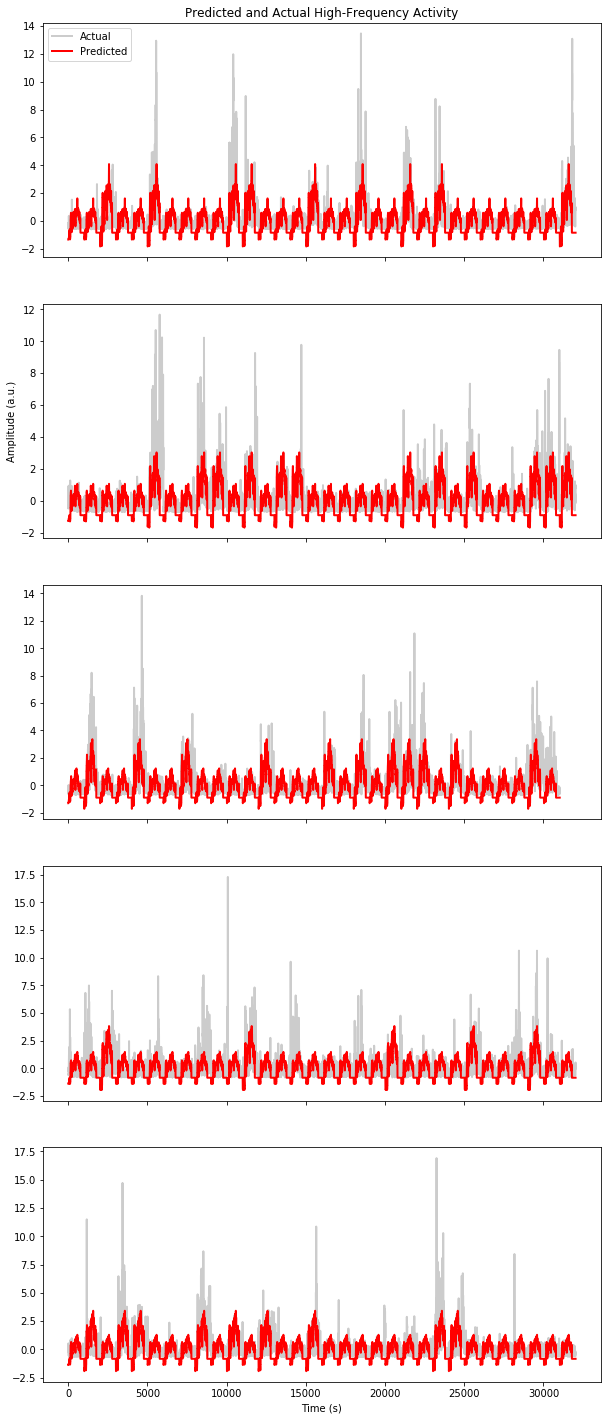

In [382]:
fig, axs = plt.subplots(len(cross_val_iterator), 1,
                        figsize=(10, 5*len(cross_val_iterator)),
                        sharex=True)
axs[0].set_title('Predicted and Actual High-Frequency Activity')
axs[1].set_ylabel('Amplitude (a.u.)')
axs[-1].set_xlabel('Time (s)')

scores_all = []


scores = []
# Iterate through cross-validation splits
for ax, (tr, tt) in zip(axs, cross_val_iterator):
    stop
    # Pull the training / testing data for the ecog data
    y_tr = y[data['trials'].isin(tr)]    
    y_tt = y[data['trials'].isin(tt)]

    # Pull the training / testing data for the spectrogram
    X_tr = X[data['trials'].isin(tr)]    
    X_tt = X[data['trials'].isin(tt)]    
    
    # Scale all the features for simplicity
    X_tr = scale(X_tr)
    X_tt = scale(X_tt)
    y_tr = scale(y_tr)
    y_tt = scale(y_tt)
    
    # Reshape since to 1D
#    X_tr = X_tr.reshape(-1,1)
#    X_tt = X_tt.reshape(-1,1)
#    y_tr = y_tr.reshape(-1,1)
#    y_tt = y_tt.reshape(-1,1)
    
    # Fit the model, and use it to predict on new data
    model.fit(X_tr, y_tr)
    predictions = model.predict(X_tt)
    
    # Plot the predicted and actual values.
    # We'll subtract the mean from each so it's easier to visualize
    ax.plot(scale(y_tt), color='k', alpha=.2, lw=2)
    ax.plot(scale(predictions), color='r', lw=2)
    ax.axis('tight')
    
    # Finally, plot the coefficient of determination (R2)
    print(r2_score(y_tt, predictions))
    scores.append(r2_score(y_tt, predictions))
_ = axs[0].legend(['Actual', 'Predicted'])

scores_all.append(np.mean(scores))

In [428]:
scores_all[60]

0.04753942788700514

In [404]:
im = plt.imread('/Users/pinheirochagas/Pedro/Stanford/code/paper-encoding_decoding_electrophysiology copy/raw_data/brain.png')

In [407]:
melec = pd.read_csv('/Users/pinheirochagas/Desktop/elec/meta_elec.csv')




In [409]:
xy = melec[['x_2d', 'y_2d']].values

Text(0.5,1,'Prediction Scores ($R^2$)')

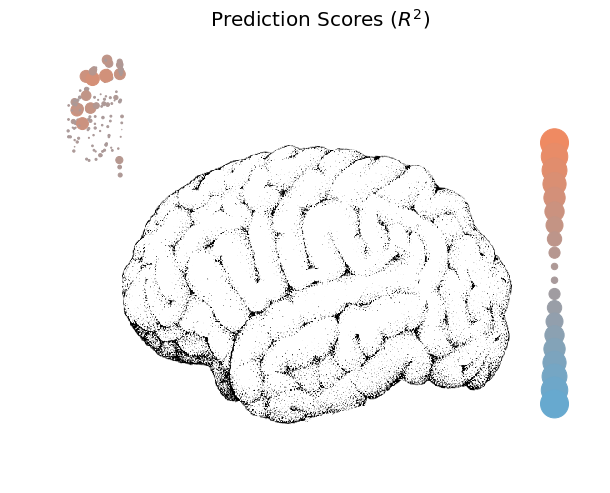

In [419]:
ax = modelingtools.plot_activity_on_brain(scores_all, im, xy[:, 0], xy[:, 1],
                                          size_scale=3000, vmin=-.1, vmax=.1,
                                          cmap=modelingtools.cmap_score)
ax.figure.set_size_inches(10, 10)
ax.set_title('Prediction Scores ($R^2$)', fontsize=20)

In [412]:
import modelingtools